# Import

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score

# Data

In [6]:
train_df = pd.read_csv("data/mitbih_train.csv", header=None)
test_df = pd.read_csv("data/mitbih_test.csv", header=None)
train_df.to_numpy()
test_df.to_numpy()

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        4.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        4.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        4.        ]])

In [7]:
x = np.copy(train_df.loc[:,train_df.columns!=187].to_numpy())
y = np.copy(train_df.loc[:,train_df.columns==187].to_numpy())
test_x = np.copy(test_df.loc[:,test_df.columns!=187].to_numpy())
test_y = np.copy(test_df.loc[:,test_df.columns==187].to_numpy())

train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.1)
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25)

In [4]:
train_y = train_y > 0
train_y = train_y.astype(int)
pd.DataFrame(train_y).value_counts()

0    65215
1    13583
dtype: int64

# Initialize Model

In [5]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="multi:softprob",
                        verbosity=1)

# Print default setting
xgboost.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': 'gpu_predictor',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': 1}

In [12]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [18]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [i/1000 for i in range(1, 300)]),
    'n_estimators': hp.choice('n_estimators', range(100,400,50)),
    'max_depth': hp.choice('max_depth', range(4,8,1)),
    'gamma': hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'min_child_weight': hp.choice('min_child_weight', range(0, 10, 1)),
    'colsample_bytree': hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'reg_alpha': hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'reg_lambda': hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

train_y = train_y > 0
train_y = train_y.astype(int)
# Objective function
def objective(params):
    global train_x, train_y
    xgboost = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="binary:logistic",
                        verbosity=1)
    scores = cross_val_score(xgboost, train_x, train_y, cv=kfold, scoring='f1', n_jobs=-1, error_score="raise")
    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    # loss = - best_score

    # Dictionary with information for evaluation
    return {'score': best_score, 'params': params, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

100%|██████████| 48/48 [04:12<00:00,  5.25s/trial, best loss: -0.9354431831212017]


In [4]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.05, 0.1]),
    'n_estimators': hp.choice('n_estimators', range(100,400,50)),
    'max_depth': hp.choice('max_depth', range(4,8,1)),
    'gamma': hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'min_child_weight': hp.choice('min_child_weight', range(0, 10, 1)),
    'colsample_bytree': hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'reg_alpha': hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'reg_lambda': hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def objective(params):
    global train_x, train_y
    xgboost = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="multi:softprob",
                        verbosity=1)

    scores = cross_val_score(xgboost, train_x, train_y, cv=kfold, scoring='recall_macro', n_jobs=-1, error_score="raise")
    print(scores)
    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

[0.8548117  0.83991029 0.84228045]                    
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                               
[0.8548117  0.83991029 0.84228045]                                               
 25%|██▌       | 12/48 [05:25<16:17, 27.15s/trial, b

KeyboardInterrupt: 

In [19]:
print(best)
print(space_eval(space, best))

{'colsample_bytree': 4, 'gamma': 3, 'learning_rate': 90, 'max_depth': 0, 'min_child_weight': 4, 'n_estimators': 5, 'reg_alpha': 0, 'reg_lambda': 0}
{'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.091, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 350, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}


In [20]:
params = space_eval(space, best)
model = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="binary:logistic",
                        **params,
                        verbosity=1)
# Print default setting
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0.3,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.091,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 350,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': 'gpu_predictor',
 'random_state': None,
 'reg_alpha': 1e-05,
 'reg_lambda': 1e-05,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': 1}


1 of kfold 3


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('auc', [0.8690604694011558, 0.8947381023775617, 0.9095051707474602, 0.93538390510099, 0.9370501855640316, 0.9366632525538894, 0.9379064892645445, 0.9392972072486122, 0.9395654106907599, 0.9416227339029715, 0.9419245439563709, 0.9429641020831591, 0.9427585101497173, 0.9440087734539966, 0.9450434210962116, 0.9495739004461676, 0.9518955643781201, 0.9519272730783357, 0.9526184266124015, 0.9565224337304324, 0.9581582035238692, 0.9602166228723352, 0.9606407545270891, 0.9613064653492186, 0.9626816964204019, 0.9631159423765391, 0.963885623523574, 0.9648219492876112, 0.9653647230253064, 0.9663870105733612, 0.9676023354351085, 0.9681746111912074, 0.9684660414003562, 0.9685229077141582, 0.9686322362412617, 0.9690991964611082, 0.9697219706483735, 0.970383770374008, 0.9707827547075347, 0.970942026907644, 0.9716526175620542, 0.971800058695266, 0.9718638188312586, 0.9722979536299164, 0.9723491745846987, 0.9726822723808226, 0.9733446731802342, 0.9736604170295152, 0.97390

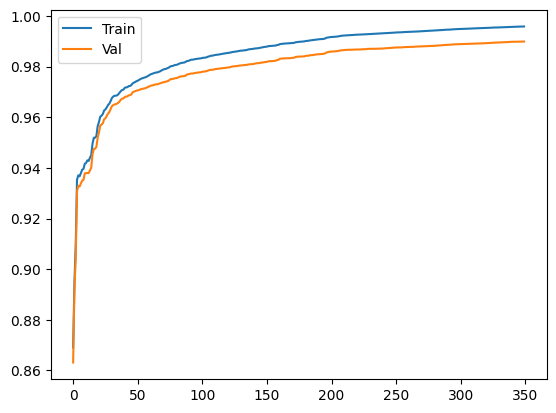

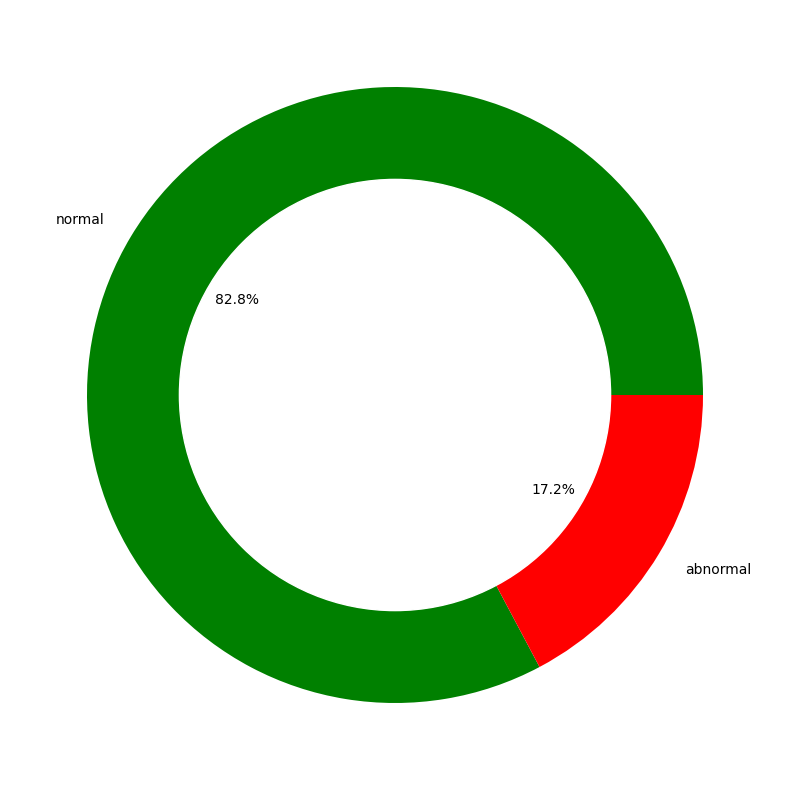

accuracy_score 0.9726840855106889
[[18032    86]
 [  512  3262]]
0.9498618274017598

2 of kfold 3


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('auc', [0.8703863012651347, 0.8989680633651976, 0.9138824483307615, 0.9221954829017462, 0.9329297867400531, 0.9337277533486344, 0.9335790452260055, 0.935794824454242, 0.9363102946214581, 0.938181608142837, 0.9390197314200633, 0.9416434946207087, 0.9419002189946436, 0.9420917206883439, 0.9422941858030615, 0.9474065251540009, 0.9504873637927196, 0.950433196135499, 0.95473734959441, 0.9570788942473885, 0.958304053458349, 0.9613093276543114, 0.962427051103025, 0.96253815506209, 0.9635600473835516, 0.9644487267291559, 0.9650007862333191, 0.9656189144496428, 0.9660548205633185, 0.9672657320614421, 0.9678842390365842, 0.9683479664264066, 0.9687252369697343, 0.9688456771278274, 0.9694899602873437, 0.9700169393706144, 0.9706406357532639, 0.9708849578343658, 0.9710569194841296, 0.9713132836254926, 0.9717826409357961, 0.9719910220985803, 0.9724800409026588, 0.9725931806903731, 0.9728708685415215, 0.9731050001577819, 0.973247550361903, 0.9737453938347574, 0.973929659

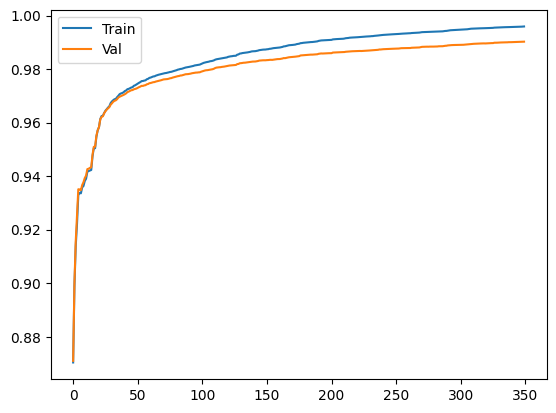

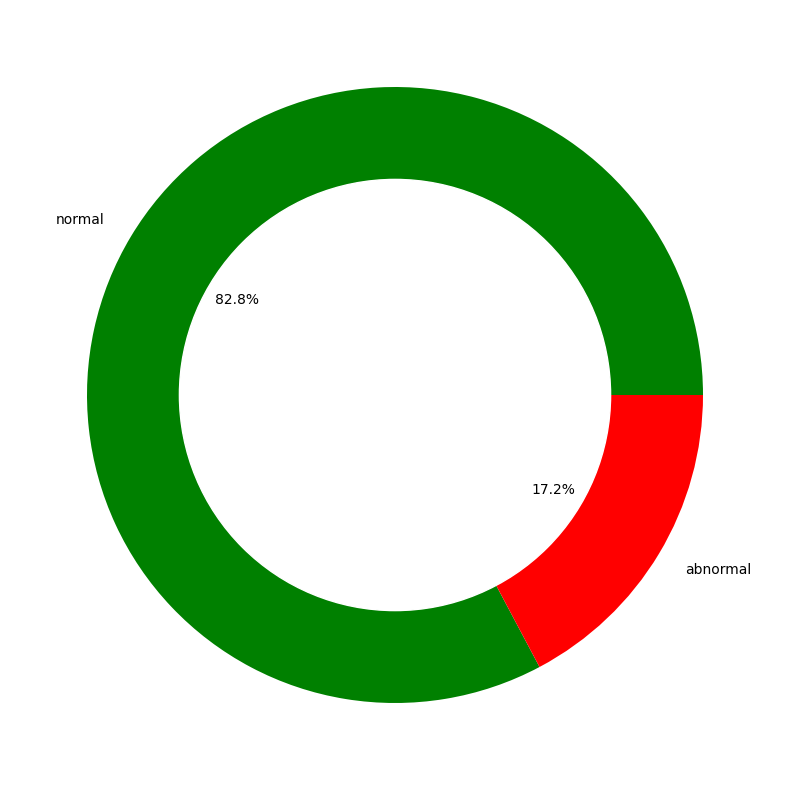

accuracy_score 0.972912479444546
[[18038    80]
 [  513  3261]]
0.9502416280785964

3 of kfold 3


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('auc', [0.8902447644764432, 0.9096834314336384, 0.9152187920267276, 0.9357949253275502, 0.9394306844209167, 0.9398110161684623, 0.9389886139214142, 0.9405264801171889, 0.9411891186398023, 0.9414934293197157, 0.9407978677850862, 0.9425854491249219, 0.9431383254066996, 0.9436461379877439, 0.9443138995372653, 0.9477211292302289, 0.952009375472681, 0.9536563802543485, 0.9557563406812811, 0.9580296391044278, 0.9589691938004731, 0.960617387231413, 0.961975075809272, 0.9630240171124, 0.9638787104834527, 0.9640698133833403, 0.9648461608740279, 0.965145456586058, 0.9657521246503704, 0.9665298655879108, 0.966986398501463, 0.967899613552935, 0.9685448041450141, 0.969094025973487, 0.9696538972761354, 0.9700402669503321, 0.9703584019814823, 0.9706649880757174, 0.970891370703495, 0.9710737311137112, 0.971278160264188, 0.9713743626411144, 0.9716425322083405, 0.9722344744004094, 0.9723700174662903, 0.9727480892365176, 0.9730922829587765, 0.9734154278121421, 0.97361040539

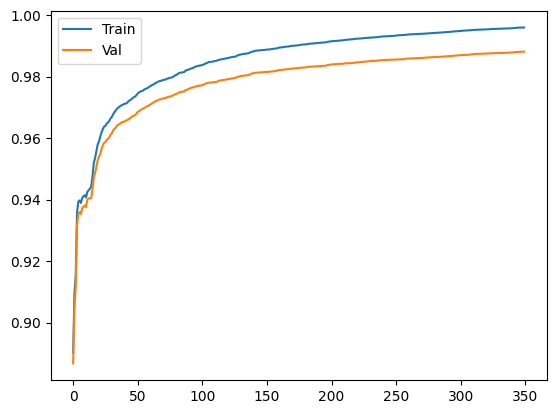

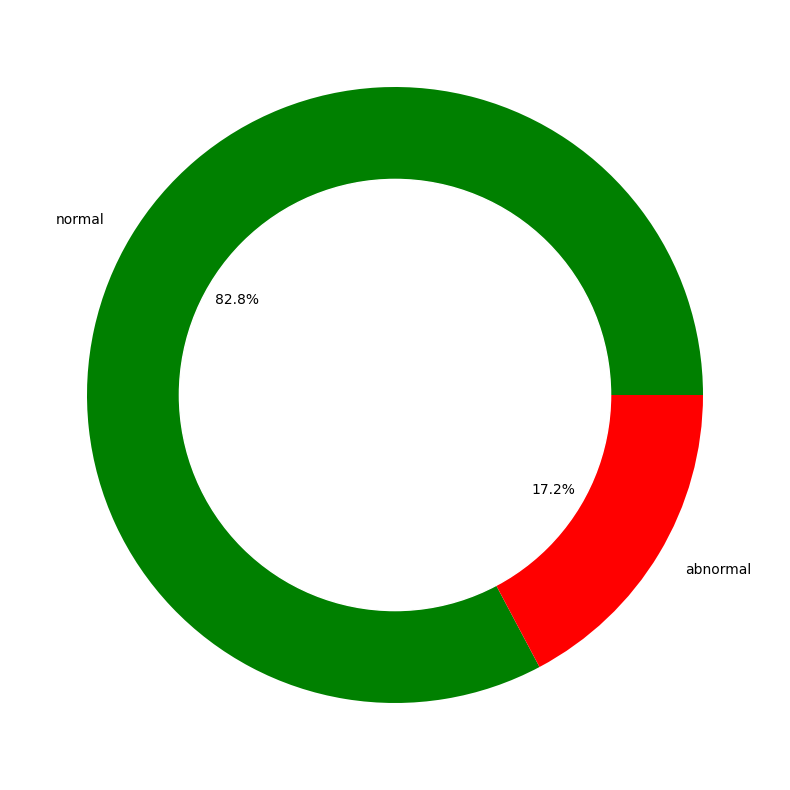

accuracy_score 0.972272976429746
[[18029    89]
 [  518  3256]]
0.9490899588260411


In [21]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
i=1
train_error_list = []
val_error_list = []
best_score = 0
test_y = test_y > 0
test_y.astype(int)
for train_index, val_index in kf.split(x, y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = pd.DataFrame(x).loc[train_index].to_numpy(),pd.DataFrame(x).loc[val_index].to_numpy()
    ytr,yvl = pd.DataFrame(y).loc[train_index].to_numpy(),pd.DataFrame(y).loc[val_index].to_numpy()
    ytr = ytr > 0
    ytr.astype(int)
    yvl = yvl > 0
    yvl.astype(int)
    model.fit(xtr,ytr, eval_metric="auc", eval_set=[(xtr, ytr), (xvl, yvl)], verbose=False, early_stopping_rounds=10)
    pred=model.predict(test_x)
    results = model.evals_result()
    print(results)
    train_error_list.append(results["validation_0"]["auc"])
    val_error_list.append(results["validation_1"]["auc"])
    plt.plot(results["validation_0"]["auc"])
    plt.plot(results["validation_1"]["auc"])
    plt.legend(['Train', 'Val'])
    plt.show()

    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(pd.DataFrame(ytr).value_counts(), labels=['normal','abnormal'], colors=['green','red'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    # print("Train error: ", results["validation_0"]["merror"])
    # print("Validation error: ", results["validation_1"]["merror"])
    score = accuracy_score(test_y,pred)
    if best_score == 0 or best_score < score:
        best_score = score
        model.save_model('best.model')
    print('accuracy_score', accuracy_score(test_y,pred))
    confusion_matrix = metrics.confusion_matrix(test_y, pred)
    print(confusion_matrix)
    print(f1_score(test_y, pred, average='macro'))
    i += 1

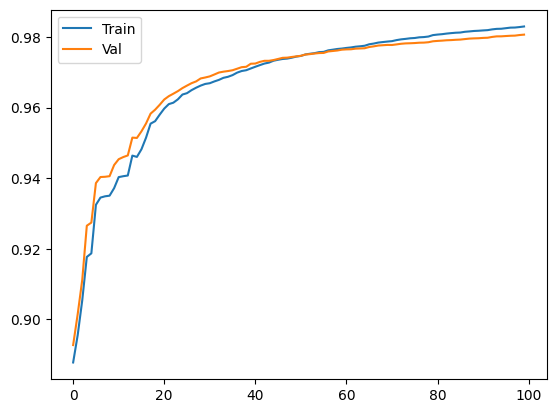

In [34]:
plt.plot(train_error_list[0])
plt.plot(val_error_list[0])
plt.legend(['Train', 'Val'])
plt.show()

In [28]:
print(results)

{'validation_0': OrderedDict([('auc', [0.8870663415990544, 0.9037974056934607, 0.9120457806377523, 0.9146702673478382, 0.9187544484749425, 0.9188035079111984, 0.9201653759736386, 0.922870179750576, 0.9257753588765866, 0.9368394380357793, 0.9400901435235287, 0.9408434285902736, 0.9411865701967369, 0.9458627839033367, 0.9453028678729248, 0.9475073778895746, 0.9525546472064311, 0.9549596969017269, 0.9558651901174566, 0.9578230702456405, 0.9600446959496318, 0.9614253676069481, 0.9628567363491819, 0.963878050854751, 0.9642706082272307, 0.9647737170490972, 0.96555103602172, 0.9662072949229051, 0.9669566236563657, 0.9674665744613999, 0.9676590252850694, 0.9680057776244788, 0.9684286094736507, 0.9690645395078786, 0.9695253021235899, 0.9698842639808325, 0.9704265521351664, 0.9706393312610866, 0.9710790574326774, 0.97159610038583, 0.9720492253470064, 0.9724053845662117, 0.9728511497084195, 0.9731021052481783, 0.9733938913220207, 0.9738382559922694, 0.9741132460026125, 0.9744956454357376, 0.97473

In [29]:
model.save_model('best.model')

In [9]:
print(pd.DataFrame(test_y).value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
dtype: int64


In [22]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score

model = XGBClassifier()
model.load_model('best.model')
results = model.predict(test_x)
test_y = test_y > 0
test_y.astype(int)
confusion_matrix = metrics.confusion_matrix(test_y, results)
print(confusion_matrix)
print(f1_score(test_y, results, average='macro'))

[[18038    80]
 [  513  3261]]
0.9502416280785964


In [12]:
print(len(test_y))

21892


In [6]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (2).

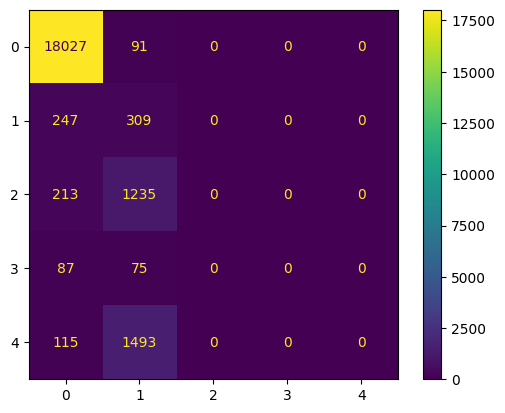

In [7]:
cm_display.plot()
plt.show()